In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib 
from time import time

# Deepface
from deepface import DeepFace
from deepface.commons import functions

# Local descriptors
from skimage.feature import hog
from skimage import  exposure
from skimage import feature

# Data transformation
from sklearn.decomposition import PCA

# Classifiers
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import plotly.express as px

# Multi-CPU
from joblib import parallel_backend


In [2]:
def lbphist(ncellsx, ncellsy, type):
    pxpercellx = int(width/ncellsx)
    pxpercelly = int(height/ncellsy)

    ofx = int((width - int(pxpercellx)*ncellsx)/2)
    ofy = int((height - int(pxpercelly)*ncellsy)/2)

    Xlbp = []

    LBPu_hist = []
    for i in range(0,ncellsy):
        for j in range(0,ncellsx):
            roi=gray[ofy+i*pxpercelly:ofy+(i+1)*pxpercelly,ofx+j*pxpercellx:ofx+(j+1)*pxpercellx]
            lbpimg = feature.local_binary_pattern(roi, 8, 1,method=type)
            
            n_bins = int(lbpimg.max()) + 1            
            feath, bins = np.histogram(lbpimg, normed=False, bins=n_bins, range=(0,n_bins))
            
            LBPu_hist= np.concatenate([LBPu_hist , feath])
            
    return LBPu_hist

In [3]:
def GetPredictions(clf, X_train, X_test, y_train, y_test):
    
    print("Normalization...")
    scaler = MinMaxScaler()
    train_X = scaler.fit_transform(X_train)
    test_X = scaler.transform(X_test)

    print("training...")
    t0 = time()
    
    clf = clf.fit(train_X, y_train)
    print("done in %0.3fs" % (time() - t0))
    try:
        print("Best estimator found by grid search:")
        print(clf.best_estimator_)
    except:
        print("Without parameters search")
        
    print("Predicting")
    t0 = time()
    # test labels
    y_pred = clf.predict(test_X)
   
    print("done in %0.3fs" % (time() - t0))
    
    return y_pred, y_test

def GetPredictionsandProbs(clf, X_train, X_test, y_train, y_test):
    
    print("Normalization...")
    scaler = MinMaxScaler()
    train_X = scaler.fit_transform(X_train)
    test_X = scaler.transform(X_test)

    print("training...")
    t0 = time()
    clf = clf.fit(train_X, y_train)
    print("done in %0.3fs" % (time() - t0))
    try:
        print("Best estimator found by grid search:")
        print(clf.best_estimator_)
    except:
        print("Without parameters search")

    print("Predicting")
    t0 = time()
    # test labels
    y_pred = clf.predict(test_X)
    
    # train and test class probabilities
    ytrain_prob = clf.predict_proba(train_X)
    ytest_prob = clf.predict_proba(test_X)
    
    print("done in %0.3fs" % (time() - t0))
    
    return y_pred, y_test, ytrain_prob, ytest_prob

In [4]:
def calc_embs(X, model, batch_size=2):
    norm_images = prewhiten(X)
    pd = []
    for start in range(0, len(norm_images), batch_size):
        pd.append(model.predict_on_batch(norm_images[start:start+batch_size]))
    return l2_normalize(np.concatenate(pd))

def l2_normalize(x, axis=-1, epsilon=1e-10):
    output = x / np.sqrt(np.maximum(np.sum(np.square(x), axis=axis, keepdims=True), epsilon))
    return output

def prewhiten(x):
    if x.ndim == 4:
        axis = (1, 2, 3)
        size = x[0].size
    elif x.ndim == 3:
        axis = (0, 1, 2)
        size = x.size
    else:
        raise ValueError('Dimension should be 3 or 4')

    mean = np.mean(x, axis=axis, keepdims=True)
    std = np.std(x, axis=axis, keepdims=True)
    std_adj = np.maximum(std, 1.0/np.sqrt(size))
    y = (x - mean) / std_adj
    return y

def get_knn():
    parameters = {'n_neighbors': [5, 10, 15, 30, 40], 'metric': ['cosine', 'euclidean']}
    return GridSearchCV(KNeighborsClassifier(), parameters, cv=K)

def compress_data(data, n_components = 0.95):
    pca = PCA(n_components=n_components)                           
    return pca.fit_transform(data)

def get_stacking():
	level0 = [
        ('lr', LogisticRegression()),
        ('knn', KNeighborsClassifier()),
        ('cart', DecisionTreeClassifier()),
        ('svm', SVC()),
        ('bayes', GaussianNB()),
        ('rf', RandomForestClassifier())
    ]

	level1 = get_svm_clf()
	model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
	return model

def get_svm_clf():
    parameters = {'C': [1e3, 5e3], 'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01]}
    return GridSearchCV(
        SVC(kernel='rbf', class_weight='balanced', probability=True), parameters, cv=K
    )

def get_rf_clf():
    n_estimators=list(range(100,1000,100))
    max_depth = list(range(4,13,4))
    min_samples_leaf=[1,2,5,7]
    min_samples_split=list(range(2,9,2))
    max_features=['auto','sqrt']


    param_grid = {"n_estimators":n_estimators,
                "max_depth":max_depth,
                "min_samples_split":min_samples_split,
                "min_samples_leaf":min_samples_leaf,
                "max_features":max_features}

    return RandomizedSearchCV(estimator = RandomForestClassifier(), param_distributions = param_grid,
                            cv = K)

In [3]:
folder = "Database_real_and_fake_face_160x160"
folder_faces = "Database_real_and_fake_only_face"

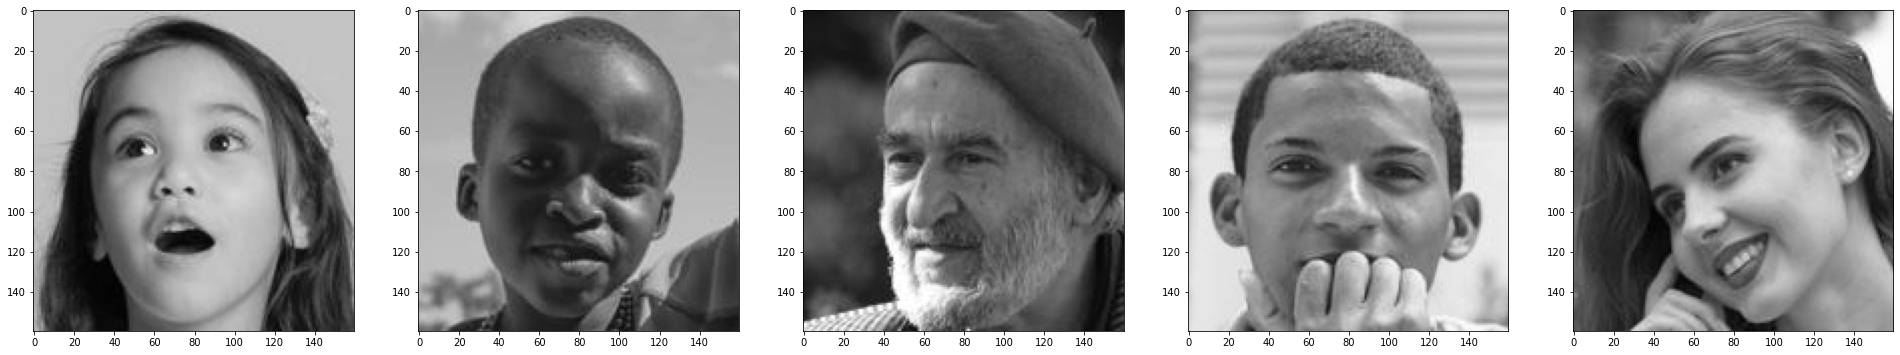

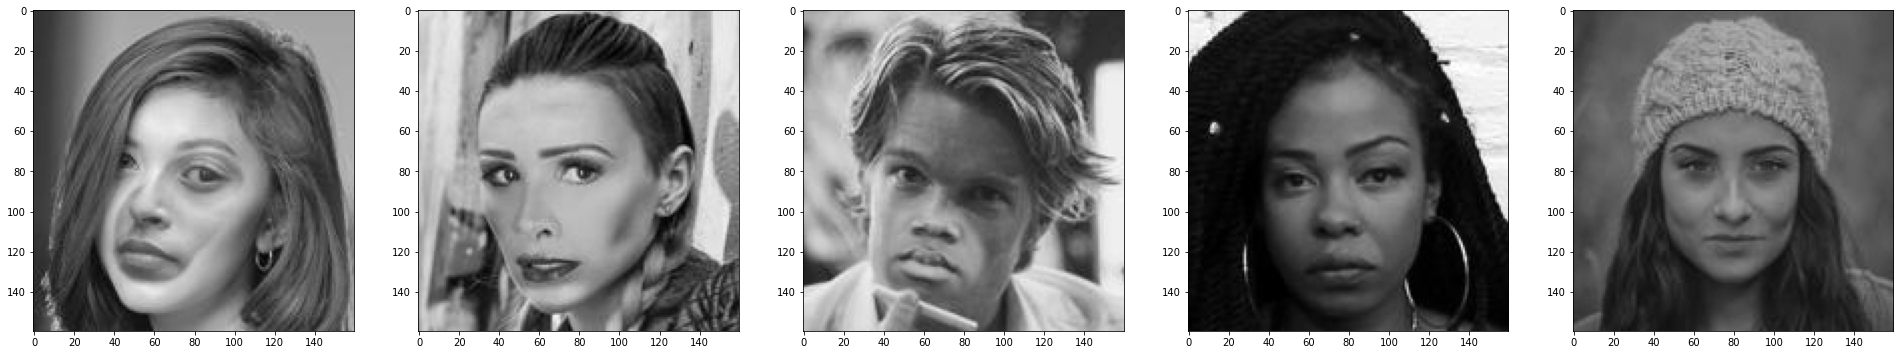

Features
(2041, 25600)
(2041, 32)
(2041, 531)
(2041,)
Dataset info:
# samples: 2041
# features: 25600
# classes: 2
classes ['real', 'fake']
samples per class 1081, 960


In [4]:
nclasses = 0
nperclass = []
classlabels = []
X = []
Y = []
Xhog = []
Xlbp = []

dpi = matplotlib.rcParams['figure.dpi']
nims2show = 5

ncellsx = 3
ncellsy = 3

for class_name in os.listdir(folder):
    nclasses += 1
    nsamples = 0    

    class_folder = os.path.join(folder, class_name)
    for file_name in os.listdir(class_folder):
        if file_name.endswith('.jpg'):
            image = cv2.imread (os.path.join(class_folder, file_name))
            
            height, width, depth = image.shape
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            X.append(gray.reshape(height*width))
            
            feat_hog, hog_image = hog(gray, orientations=8, pixels_per_cell=(height/ncellsy, width/ncellsx),
                    cells_per_block=(1, 1), visualize=True, multichannel=False, block_norm='L1')
            Xhog.append(feat_hog)
            
            feat_lbp = lbphist(ncellsx, ncellsy, "nri_uniform")
            Xlbp.append(feat_lbp)
            
            Y.append(nclasses-1)
            
            if nsamples < nims2show:
                if nsamples == 0:                    
                    figsize = 15*width / float(dpi), 15*height / float(dpi)
                    fig = plt.figure(figsize=figsize)                
                
                fig.add_subplot(1,nims2show, nsamples + 1)
                plt.imshow(gray, cmap='gray', vmin=0, vmax=255)                
                
            nsamples += 1
    plt.show()
    nperclass.append(nsamples)
    classlabels.append(class_name)
    
X = np.array(X,dtype='float32')
Y = np.array(Y,dtype='float64')
Xhog = np.array(Xhog,dtype='float32')
Xlbp = np.array(Xlbp,dtype='float32')

print("Features")
print(X.shape)
print(Xhog.shape)
print(Xlbp.shape)

print(Y.shape)
n_samples , n_features = X.shape
class_names = np.array(classlabels)
n_classes = class_names.shape[0]

print("Dataset info:")
print("# samples: %d" % n_samples)
print("# features: %d" % n_features)
print("# classes: %d" % n_classes)
print("classes %s" % classlabels)
print("samples per class %s" % str(nperclass)[1:-1] )

In [7]:
# ['VGG-Face', 'Facenet', 'OpenFace', 'DeepFace', 'DeepID', 'Dlib']
def get_deeplearning_embeaddings(mode_name: str, database: str, preprocessing: bool = True) -> np.array:
    model = DeepFace.build_model(mode_name)
    target_size = model.layers[0].input_shape[0]
    dim = (int(target_size[1]), int(target_size[2]))

    nclasses = 0
    nperclass = []
    classlabels = []
    X = []
    Y = []

    for class_name in os.listdir(database):
        nclasses += 1
        nsamples = 0    

        class_folder = os.path.join(database, class_name)
        for file_name in os.listdir(class_folder):
            if file_name.endswith('.jpg'):
                image = cv2.imread (os.path.join(class_folder, file_name))  
                
                img1 = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
                
                if preprocessing:
                    img_embedding = calc_embs(np.array([img1]), model)
                else:
                    img_embedding = model.predict(img1[None,...])
                
                X.append(img_embedding[0])

                Y.append(nclasses-1)
                
                nsamples += 1
                
        nperclass.append(nsamples)
        classlabels.append(class_name)
                
    X = np.array(X,dtype='float32')
    Y = np.array(Y,dtype='float64')
    print("Features")
    print(X.shape)

    return X, Y

In [25]:
facenet_emb, y_facenet = get_deeplearning_embeaddings("Facenet", folder_faces)

Features
(2041, 128)


In [26]:
open_emb, y_open = get_deeplearning_embeaddings("OpenFace", folder_faces)

Features
(2041, 128)


In [27]:
vgg_emb, y_vgg = get_deeplearning_embeaddings("VGG-Face", folder_faces)
vgg_emb_pca = compress_data(vgg_emb)
print(vgg_emb_pca.shape)

Features
(2041, 2622)
(2041, 302)


In [28]:
deep_emb, y_deep = get_deeplearning_embeaddings("DeepFace", folder_faces)
deep_emb_pca = compress_data(deep_emb)
print(deep_emb_pca.shape)

Features
(2041, 4096)
(2041, 641)


In [12]:
# StratifiedKFold
K = 5
skf = StratifiedKFold(n_splits=K, random_state=7, shuffle=True)

fold = 1
for train_index, test_index in skf.split(X, Y):
    print("Fold %d" % fold)
    print("# samples in training set %d" % train_index.shape[0])
    print("# samples in test set %d" % test_index.shape[0])
    fold += 1

Fold 1
# samples in training set 1632
# samples in test set 409
Fold 2
# samples in training set 1633
# samples in test set 408
Fold 3
# samples in training set 1633
# samples in test set 408
Fold 4
# samples in training set 1633
# samples in test set 408
Fold 5
# samples in training set 1633
# samples in test set 408


In [5]:
def TSNE_plot(data, y, title, jobs = 1):
  print(data.shape)
  with parallel_backend('threading', n_jobs = jobs):
    X_embedded = TSNE(n_components=2).fit_transform(data)
  plt.scatter(X_embedded[:,0], X_embedded[:,1], c=y)
  plt.title(title)
  plt.show()

In [14]:
def kflod_experiment(clf, emb, y, name_test, jobs = 1):

    print("+++++++++++++++++++++++++++++++++++++++++++\n")

    precs_hog_svm, recs_hog_svm, acc = [], [], []

    fold = 1
    with parallel_backend('threading', n_jobs = jobs):
        for train_index, test_index in skf.split(emb, y):
            print("*********************\nFold %d" % fold)
            print(name_test)
            y_pred, y_test, hog_train_prob, hog_test_prob = GetPredictionsandProbs(clf, emb[train_index], emb[test_index], y[train_index], y[test_index])
            print("\n%s Metrics" % name_test)
            precs_hog_svm.append(precision_score(y_test, y_pred))
            recs_hog_svm.append(recall_score(y_test, y_pred))
            acc.append(accuracy_score(y_test, y_pred))
            print(classification_report(y_test, y_pred, target_names=class_names))
            if fold == 1:
                print("Confussion matrix:")
                print(confusion_matrix(y_test, y_pred, labels=range(n_classes))) 
            
            fold += 1

    print("\n********K-FOLD SUMMARY*********")
    print(
        "%s Mean Precision:  %0.3f, Mean Recall:  %0.3f, Accuracy: %0.3f" 
        % (name_test, np.mean(precs_hog_svm)*100 , np.mean(recs_hog_svm)*100, np.mean(acc)*100 )) 

(2041, 32)


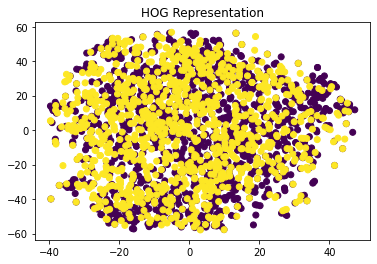

In [15]:
TSNE_plot(Xhog, Y, "HOG Representation")

(2041, 531)


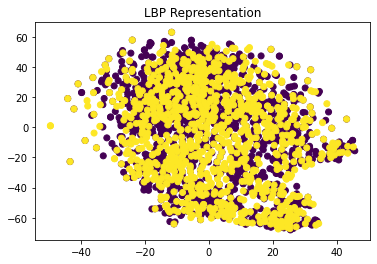

In [6]:
TSNE_plot(Xlbp, Y, "LBP Representation")

(2035, 128)


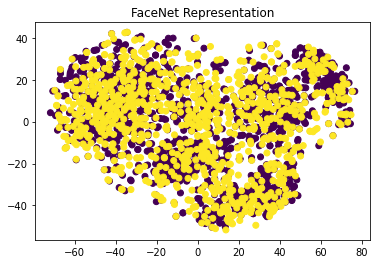

In [19]:
TSNE_plot(facenet_emb, y_facenet, "FaceNet Representation")

(2035, 2622)


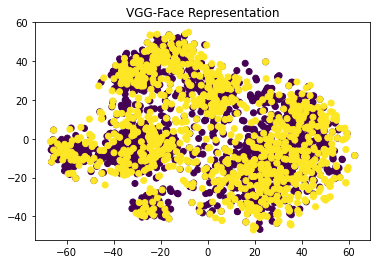

In [18]:
TSNE_plot(vgg_emb, y_vgg, "VGG-Face Representation", jobs = 4)

(2035, 302)


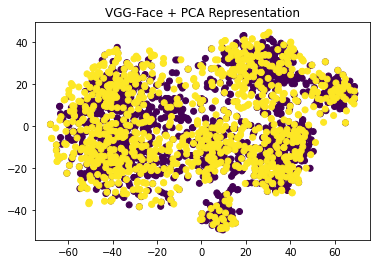

In [19]:
TSNE_plot(vgg_emb_pca, y_vgg, "VGG-Face + PCA Representation", jobs = 4)

# HOG

## Baseline: HOG + SVM

In [16]:
svm_hog = get_svm_clf()
kflod_experiment(svm_hog, Xhog, Y, "HOG + SVM")

+++++++++++++++++++++++++++++++++++++++++++

*********************
Fold 1
HOG + SVM
Normalization...
training...
done in 22.772s
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.005, probability=True)
Predicting
done in 0.121s

HOG + SVM Metrics
              precision    recall  f1-score   support

        real       0.59      0.49      0.54       217
        fake       0.52      0.62      0.56       192

    accuracy                           0.55       409
   macro avg       0.55      0.55      0.55       409
weighted avg       0.56      0.55      0.55       409

Confussion matrix:
[[106 111]
 [ 73 119]]
*********************
Fold 2
HOG + SVM
Normalization...
training...
done in 23.627s
Best estimator found by grid search:
SVC(C=5000.0, class_weight='balanced', gamma=0.01, probability=True)
Predicting
done in 0.128s

HOG + SVM Metrics
              precision    recall  f1-score   support

        real       0.66      0.52      0.58       216
      

In [17]:
rf_hog = get_rf_clf()
kflod_experiment(rf_hog, Xhog, Y, "HOG + RF")

+++++++++++++++++++++++++++++++++++++++++++

*********************
Fold 1
HOG + RF
Normalization...
training...
done in 78.456s
Best estimator found by grid search:
RandomForestClassifier(max_depth=4, min_samples_leaf=5, min_samples_split=4,
                       n_estimators=600)
Predicting
done in 0.239s

HOG + RF Metrics
              precision    recall  f1-score   support

        real       0.56      0.60      0.58       217
        fake       0.51      0.46      0.48       192

    accuracy                           0.54       409
   macro avg       0.53      0.53      0.53       409
weighted avg       0.53      0.54      0.53       409

Confussion matrix:
[[131  86]
 [104  88]]
*********************
Fold 2
HOG + RF
Normalization...
training...
done in 61.946s
Best estimator found by grid search:
RandomForestClassifier(max_depth=4, max_features='sqrt', min_samples_leaf=2,
                       min_samples_split=8)
Predicting
done in 0.030s

HOG + RF Metrics
              preci

In [20]:
pca = PCA(n_components=0.95)                           
Xhog_pca = pca.fit_transform(Xhog)

print(Xhog_pca.shape)

svm_hog_pca = get_svm_clf()
kflod_experiment(svm_hog_pca, Xhog_pca, Y, "HOG + PCA + SVM")    

(2041, 18)
+++++++++++++++++++++++++++++++++++++++++++

*********************
Fold 1
HOG + PCA + SVM
Normalization...
training...
done in 15.810s
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.005, probability=True)
Predicting
done in 0.086s

HOG + PCA + SVM Metrics
              precision    recall  f1-score   support

        real       0.58      0.50      0.53       217
        fake       0.51      0.59      0.55       192

    accuracy                           0.54       409
   macro avg       0.54      0.54      0.54       409
weighted avg       0.55      0.54      0.54       409

Confussion matrix:
[[108 109]
 [ 79 113]]
*********************
Fold 2
HOG + PCA + SVM
Normalization...
training...
done in 15.996s
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.005, probability=True)
Predicting
done in 0.082s

HOG + PCA + SVM Metrics
              precision    recall  f1-score   support

        real       0.64 

In [21]:
stack_model = get_stacking()
kflod_experiment(stack_model, Xhog, Y, "HOG + Stacking")

+++++++++++++++++++++++++++++++++++++++++++

*********************
Fold 1
HOG + Stacking
Normalization...
training...
done in 18.010s
Best estimator found by grid search:
Without parameters search
Predicting
done in 0.534s

HOG + Stacking Metrics
              precision    recall  f1-score   support

        real       0.59      0.47      0.53       217
        fake       0.51      0.62      0.56       192

    accuracy                           0.55       409
   macro avg       0.55      0.55      0.54       409
weighted avg       0.55      0.55      0.54       409

Confussion matrix:
[[103 114]
 [ 72 120]]
*********************
Fold 2
HOG + Stacking
Normalization...
training...
done in 15.853s
Best estimator found by grid search:
Without parameters search
Predicting
done in 0.516s

HOG + Stacking Metrics
              precision    recall  f1-score   support

        real       0.62      0.49      0.54       216
        fake       0.53      0.66      0.59       192

    accuracy      

# LIB

In [24]:
svm_lib = get_svm_clf()
kflod_experiment(svm_lib, Xlbp, Y, "LIB + SVM")

+++++++++++++++++++++++++++++++++++++++++++

*********************
Fold 1
LIB + SVM
Normalization...
training...
done in 257.636s
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.0001, probability=True)
Predicting
done in 1.948s

LIB + SVM Metrics
              precision    recall  f1-score   support

        real       0.64      0.60      0.62       217
        fake       0.58      0.61      0.60       192

    accuracy                           0.61       409
   macro avg       0.61      0.61      0.61       409
weighted avg       0.61      0.61      0.61       409

Confussion matrix:
[[131  86]
 [ 74 118]]
*********************
Fold 2
LIB + SVM
Normalization...
training...
done in 259.301s
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.0001, probability=True)
Predicting
done in 1.749s

LIB + SVM Metrics
              precision    recall  f1-score   support

        real       0.64      0.53      0.58       216
 

In [62]:
rf_lib = get_rf_clf()
kflod_experiment(rf_lib, Xlbp, Y, "LIB + RF")                           

+++++++++++++++++++++++++++++++++++++++++++

*********************
Fold 1
LIB + RF
SVM Normalization...
SVM training...
done in 168.519s
Best estimator found by grid search:
RandomForestClassifier(max_depth=8, max_features='sqrt', min_samples_leaf=7,
                       n_estimators=900)
Predicting
done in 0.351s

LIB + RF Metrics
              precision    recall  f1-score   support

        real       0.60      0.74      0.66       217
        fake       0.60      0.45      0.52       192

    accuracy                           0.60       409
   macro avg       0.60      0.60      0.59       409
weighted avg       0.60      0.60      0.60       409

Confussion matrix:
[[160  57]
 [105  87]]
*********************
Fold 2
LIB + RF
SVM Normalization...
SVM training...
done in 154.205s
Best estimator found by grid search:
RandomForestClassifier(max_depth=4, min_samples_leaf=5, min_samples_split=8,
                       n_estimators=500)
Predicting
done in 0.156s

LIB + RF Metrics
    

In [23]:
pca = PCA(n_components=0.95)                           
Xlbp_pca = pca.fit_transform(Xlbp)

print(Xlbp_pca.shape)
svm_pca_lib = get_svm_clf()
kflod_experiment(svm_pca_lib, Xlbp_pca, Y, "LIB + PCA + SVM")    

(2041, 84)
+++++++++++++++++++++++++++++++++++++++++++

*********************
Fold 1
LIB + PCA + SVM
Normalization...
training...
done in 60.525s
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.005, probability=True)
Predicting
done in 0.270s

LIB + PCA + SVM Metrics
              precision    recall  f1-score   support

        real       0.67      0.55      0.61       217
        fake       0.58      0.69      0.63       192

    accuracy                           0.62       409
   macro avg       0.62      0.62      0.62       409
weighted avg       0.63      0.62      0.62       409

Confussion matrix:
[[120  97]
 [ 59 133]]
*********************
Fold 2
LIB + PCA + SVM
Normalization...
training...
done in 58.949s
Best estimator found by grid search:
SVC(C=5000.0, class_weight='balanced', gamma=0.001, probability=True)
Predicting
done in 0.263s

LIB + PCA + SVM Metrics
              precision    recall  f1-score   support

        real       0.64 

In [119]:
stack_model = get_stacking()
kflod_experiment(stack_model, Xlbp, Y, "LIB + Stacking")    

+++++++++++++++++++++++++++++++++++++++++++

*********************
Fold 1
LIB + Stacking
Normalization...
training...
done in 18.645s
Best estimator found by grid search:
Without parameters search
Predicting
done in 5.568s

LIB + Stacking Metrics
              precision    recall  f1-score   support

        real       0.64      0.54      0.58       217
        fake       0.56      0.65      0.60       192

    accuracy                           0.59       409
   macro avg       0.60      0.60      0.59       409
weighted avg       0.60      0.59      0.59       409

Confussion matrix:
[[117 100]
 [ 67 125]]
*********************
Fold 2
LIB + Stacking
Normalization...
training...
done in 17.938s
Best estimator found by grid search:
Without parameters search
Predicting
done in 5.494s

LIB + Stacking Metrics
              precision    recall  f1-score   support

        real       0.65      0.53      0.58       216
        fake       0.56      0.68      0.62       192

    accuracy      

## FACE-NET

In [34]:
svm_facenet = get_svm_clf()
kflod_experiment(svm_facenet, facenet_emb, y_facenet, "FaceNet + SVM")

+++++++++++++++++++++++++++++++++++++++++++

*********************
Fold 1
FaceNet + SVM
Normalization...
training...
done in 114.113s
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.005, probability=True)
Predicting
done in 0.429s

FaceNet + SVM Metrics
              precision    recall  f1-score   support

        real       0.62      0.60      0.61       217
        fake       0.56      0.58      0.57       192

    accuracy                           0.59       409
   macro avg       0.59      0.59      0.59       409
weighted avg       0.59      0.59      0.59       409

Confussion matrix:
[[130  87]
 [ 80 112]]
*********************
Fold 2
FaceNet + SVM
Normalization...
training...
done in 114.180s
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.005, probability=True)
Predicting
done in 0.432s

FaceNet + SVM Metrics
              precision    recall  f1-score   support

        real       0.62      0.50      0.

In [35]:
knn_facenet = get_knn()
kflod_experiment(knn_facenet, facenet_emb, y_facenet, "FaceNet + KNN")

+++++++++++++++++++++++++++++++++++++++++++

*********************
Fold 1
FaceNet + KNN
Normalization...
training...
done in 3.009s
Best estimator found by grid search:
KNeighborsClassifier(metric='euclidean', n_neighbors=30)
Predicting
done in 0.679s

FaceNet + KNN Metrics
              precision    recall  f1-score   support

        real       0.54      0.68      0.61       217
        fake       0.50      0.35      0.41       192

    accuracy                           0.53       409
   macro avg       0.52      0.52      0.51       409
weighted avg       0.52      0.53      0.52       409

Confussion matrix:
[[148  69]
 [124  68]]
*********************
Fold 2
FaceNet + KNN
Normalization...
training...
done in 2.969s
Best estimator found by grid search:
KNeighborsClassifier(metric='cosine')
Predicting
done in 0.097s

FaceNet + KNN Metrics
              precision    recall  f1-score   support

        real       0.57      0.58      0.58       216
        fake       0.52      0.51   

In [36]:
rf_facenet = get_rf_clf()
kflod_experiment(rf_facenet, facenet_emb, y_facenet, "FaceNet + RF")

+++++++++++++++++++++++++++++++++++++++++++

*********************
Fold 1
FaceNet + RF
Normalization...
training...
done in 118.870s
Best estimator found by grid search:
RandomForestClassifier(max_depth=8, max_features='sqrt', min_samples_leaf=2,
                       min_samples_split=4, n_estimators=800)
Predicting
done in 0.286s

FaceNet + RF Metrics
              precision    recall  f1-score   support

        real       0.56      0.75      0.64       217
        fake       0.55      0.34      0.42       192

    accuracy                           0.56       409
   macro avg       0.56      0.55      0.53       409
weighted avg       0.56      0.56      0.54       409

Confussion matrix:
[[163  54]
 [126  66]]
*********************
Fold 2
FaceNet + RF
Normalization...
training...
done in 85.154s
Best estimator found by grid search:
RandomForestClassifier(max_depth=12, min_samples_split=6, n_estimators=600)
Predicting
done in 0.243s

FaceNet + RF Metrics
              precision   

In [37]:
stack_model = get_stacking()
kflod_experiment(stack_model, facenet_emb, y_facenet, "FaceNet + Stacking")

+++++++++++++++++++++++++++++++++++++++++++

*********************
Fold 1
FaceNet + Stacking
Normalization...
training...
done in 18.426s
Best estimator found by grid search:
Without parameters search
Predicting
done in 1.320s

FaceNet + Stacking Metrics
              precision    recall  f1-score   support

        real       0.60      0.63      0.62       217
        fake       0.56      0.53      0.54       192

    accuracy                           0.58       409
   macro avg       0.58      0.58      0.58       409
weighted avg       0.58      0.58      0.58       409

Confussion matrix:
[[137  80]
 [ 91 101]]
*********************
Fold 2
FaceNet + Stacking
Normalization...
training...
done in 18.698s
Best estimator found by grid search:
Without parameters search
Predicting
done in 1.305s

FaceNet + Stacking Metrics
              precision    recall  f1-score   support

        real       0.62      0.48      0.54       216
        fake       0.53      0.68      0.60       192

  

## VGG-FACE

In [38]:
svm_vgg_pca = get_svm_clf()
kflod_experiment(svm_vgg_pca, vgg_emb_pca, y_vgg, "VggFace + PCA + SVM")

+++++++++++++++++++++++++++++++++++++++++++

*********************
Fold 1
VggFace + PCA + SVM
Normalization...
training...
done in 156.245s
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.0001, probability=True)
Predicting
done in 0.943s

VggFace + PCA + SVM Metrics
              precision    recall  f1-score   support

        real       0.58      0.53      0.55       217
        fake       0.51      0.56      0.54       192

    accuracy                           0.54       409
   macro avg       0.54      0.54      0.54       409
weighted avg       0.55      0.54      0.54       409

Confussion matrix:
[[114 103]
 [ 84 108]]
*********************
Fold 2
VggFace + PCA + SVM
Normalization...
training...
done in 159.212s
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.005, probability=True)
Predicting
done in 0.983s

VggFace + PCA + SVM Metrics
              precision    recall  f1-score   support

        real    

# Open-face


In [39]:
svm_open = get_svm_clf()
kflod_experiment(svm_open,open_emb, y_open, "Openface + SVM")

+++++++++++++++++++++++++++++++++++++++++++

*********************
Fold 1
Openface + SVM
Normalization...
training...
done in 83.853s
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.01, probability=True)
Predicting
done in 0.390s

Openface + SVM Metrics
              precision    recall  f1-score   support

        real       0.61      0.57      0.59       217
        fake       0.54      0.58      0.56       192

    accuracy                           0.57       409
   macro avg       0.57      0.58      0.57       409
weighted avg       0.58      0.57      0.57       409

Confussion matrix:
[[123  94]
 [ 80 112]]
*********************
Fold 2
Openface + SVM
Normalization...
training...
done in 83.764s
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.01, probability=True)
Predicting
done in 0.387s

Openface + SVM Metrics
              precision    recall  f1-score   support

        real       0.59      0.48      0.

# Deep face


In [40]:
svm_deep = get_svm_clf()
kflod_experiment(svm_deep, deep_emb_pca, y_open, "DeepFace + PCA +  SVM")

+++++++++++++++++++++++++++++++++++++++++++

*********************
Fold 1
DeepFace + PCA +  SVM
Normalization...
training...
done in 263.782s
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.0001, probability=True)
Predicting
done in 1.889s

DeepFace + PCA +  SVM Metrics
              precision    recall  f1-score   support

        real       0.62      0.58      0.60       217
        fake       0.55      0.59      0.57       192

    accuracy                           0.58       409
   macro avg       0.58      0.58      0.58       409
weighted avg       0.59      0.58      0.58       409

Confussion matrix:
[[125  92]
 [ 78 114]]
*********************
Fold 2
DeepFace + PCA +  SVM
Normalization...
training...
done in 262.322s
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.0001, probability=True)
Predicting
done in 1.889s

DeepFace + PCA +  SVM Metrics
              precision    recall  f1-score   support

       

# Stacking


In [43]:
def build_score_dataset(stack, samples) -> np.array:
    ds = np.zeros((samples, len(stack)))
    print(ds.shape)
    for index, (emb, model) in enumerate(stack):
        scores = model.predict_proba(emb)
        for row, score in enumerate(scores):
            ds[row][index] = score[1]
    return ds

In [70]:
level0 = [
    (facenet_emb, svm_facenet),
    (open_emb, svm_open),
    (vgg_emb_pca, svm_vgg_pca),
    (deep_emb_pca,svm_deep)
]

level1 = get_svm_clf()

scores = build_score_dataset(level0, len(y_open))

(2041, 4)


(2041, 4)


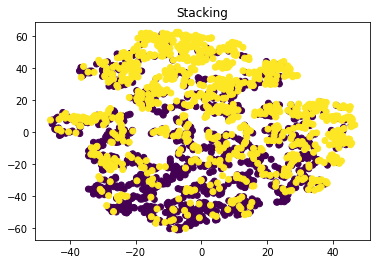

In [71]:
TSNE_plot(scores, y_facenet, 'Stacking')

In [72]:
svm_stacking = get_svm_clf()
kflod_experiment(svm_stacking,scores, y_open, "Stacking(SVM) + SVM")

+++++++++++++++++++++++++++++++++++++++++++

*********************
Fold 1
Stacking(SVM) + SVM
Normalization...
training...
done in 7.415s
Best estimator found by grid search:
SVC(C=5000.0, class_weight='balanced', gamma=0.01, probability=True)
Predicting
done in 0.033s

Stacking(SVM) + SVM Metrics
              precision    recall  f1-score   support

        real       0.74      0.74      0.74       217
        fake       0.70      0.70      0.70       192

    accuracy                           0.72       409
   macro avg       0.72      0.72      0.72       409
weighted avg       0.72      0.72      0.72       409

Confussion matrix:
[[160  57]
 [ 57 135]]
*********************
Fold 2
Stacking(SVM) + SVM
Normalization...
training...
done in 7.379s
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.01, probability=True)
Predicting
done in 0.033s

Stacking(SVM) + SVM Metrics
              precision    recall  f1-score   support

        real       0.74

In [32]:
level0 = [
    (Xhog, svm_hog),
    (Xlbp, svm_lib)
]

level1 = get_svm_clf()
scores = build_score_dataset(level0, len(y_open))

(2041, 2)


In [33]:
svm_stacking = get_svm_clf()
kflod_experiment(svm_stacking,scores, Y, "ML Stacking(SVM) + SVM")

+++++++++++++++++++++++++++++++++++++++++++

*********************
Fold 1
ML Stacking(SVM) + SVM
Normalization...
training...
done in 8.521s
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.0001, probability=True)
Predicting
done in 0.044s

ML Stacking(SVM) + SVM Metrics
              precision    recall  f1-score   support

        real       0.61      0.56      0.58       217
        fake       0.55      0.60      0.57       192

    accuracy                           0.58       409
   macro avg       0.58      0.58      0.58       409
weighted avg       0.58      0.58      0.58       409

Confussion matrix:
[[121  96]
 [ 76 116]]
*********************
Fold 2
ML Stacking(SVM) + SVM
Normalization...
training...
done in 8.738s
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.0001, probability=True)
Predicting
done in 0.046s

ML Stacking(SVM) + SVM Metrics
              precision    recall  f1-score   support

       

## Fake Face detection in the wild

In [113]:
def get_level_fake_face(level):
    return [i+1081 for i,face in enumerate(os.listdir(os.path.join(folder_faces, "fake"))) if level in face]

def create_level_score(level):
    index_level = get_level_fake_face(level)
    x_scores = list(scores[index_level])
    x_scores[len(x_scores):] = scores[:len(x_scores)]
    y_scores = list(Y[index_level])
    y_scores[len(y_scores):] = Y[:len(y_scores)]
    return np.array(x_scores), np.array(y_scores)

### Easy

In [114]:
x_level, y_level = create_level_score('easy')

svm_level = get_svm_clf()
kflod_experiment(svm_level, x_level, y_level, "Easy Stacking(SVM) + SVM")

+++++++++++++++++++++++++++++++++++++++++++

*********************
Fold 1
Easy Stacking(SVM) + SVM
Normalization...
training...
done in 0.558s
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.001, probability=True)
Predicting
done in 0.003s

Easy Stacking(SVM) + SVM Metrics
              precision    recall  f1-score   support

        real       0.60      0.60      0.60        48
        fake       0.60      0.60      0.60        48

    accuracy                           0.60        96
   macro avg       0.60      0.60      0.60        96
weighted avg       0.60      0.60      0.60        96

Confussion matrix:
[[29 19]
 [19 29]]
*********************
Fold 2
Easy Stacking(SVM) + SVM
Normalization...
training...
done in 0.555s
Best estimator found by grid search:
SVC(C=5000.0, class_weight='balanced', gamma=0.005, probability=True)
Predicting
done in 0.003s

Easy Stacking(SVM) + SVM Metrics
              precision    recall  f1-score   support

     

### Mid

In [118]:
x_level, y_level = create_level_score('mid')

svm_level = get_svm_clf()
kflod_experiment(svm_level, x_level, y_level, "Mid Stacking(SVM) + SVM")

+++++++++++++++++++++++++++++++++++++++++++

*********************
Fold 1
Mid Stacking(SVM) + SVM
Normalization...
training...
done in 1.501s
Best estimator found by grid search:
SVC(C=5000.0, class_weight='balanced', gamma=0.01, probability=True)
Predicting
done in 0.007s

Mid Stacking(SVM) + SVM Metrics
              precision    recall  f1-score   support

        real       0.73      0.77      0.75        96
        fake       0.76      0.72      0.74        96

    accuracy                           0.74       192
   macro avg       0.75      0.74      0.74       192
weighted avg       0.75      0.74      0.74       192

Confussion matrix:
[[74 22]
 [27 69]]
*********************
Fold 2
Mid Stacking(SVM) + SVM
Normalization...
training...
done in 1.450s
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.0005, probability=True)
Predicting
done in 0.007s

Mid Stacking(SVM) + SVM Metrics
              precision    recall  f1-score   support

        r

### Hard

In [117]:
x_level, y_level = create_level_score('hard')

svm_level = get_svm_clf()
kflod_experiment(svm_level, x_level, y_level, "Hard Stacking(SVM) + SVM")

+++++++++++++++++++++++++++++++++++++++++++

*********************
Fold 1
Hard Stacking(SVM) + SVM
Normalization...
training...
done in 0.547s
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.005, probability=True)
Predicting
done in 0.002s

Hard Stacking(SVM) + SVM Metrics
              precision    recall  f1-score   support

        real       0.74      0.67      0.70        48
        fake       0.70      0.77      0.73        48

    accuracy                           0.72        96
   macro avg       0.72      0.72      0.72        96
weighted avg       0.72      0.72      0.72        96

Confussion matrix:
[[32 16]
 [11 37]]
*********************
Fold 2
Hard Stacking(SVM) + SVM
Normalization...
training...
done in 0.520s
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.001, probability=True)
Predicting
done in 0.002s

Hard Stacking(SVM) + SVM Metrics
              precision    recall  f1-score   support

     